Предисловие для проверяющего: в схемах SegNet указано 5 блоков в энкодере и в декодере, а в схемах U-Net в 2 раза больше каналов, чем в моей имплементации. Это связано с тем, что при попытке поставить больше блоков или каналов, у меня возникает ошибка нехватки памяти CUDA, так что я решил сделать модели чуть меньше по занимаемой памяти, но более стабильными в техническом плане.

# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>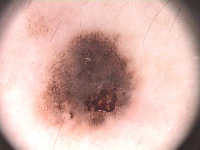</td><td>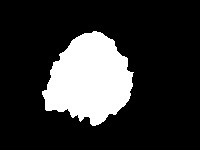</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [0]:
# ! wget https://www.dropbox.com/s/8ne5sjskljb472e/PH2Dataset.rar

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -q /content/gdrive/My\ Drive/PH2Dataset.zip

replace PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [0]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [0]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

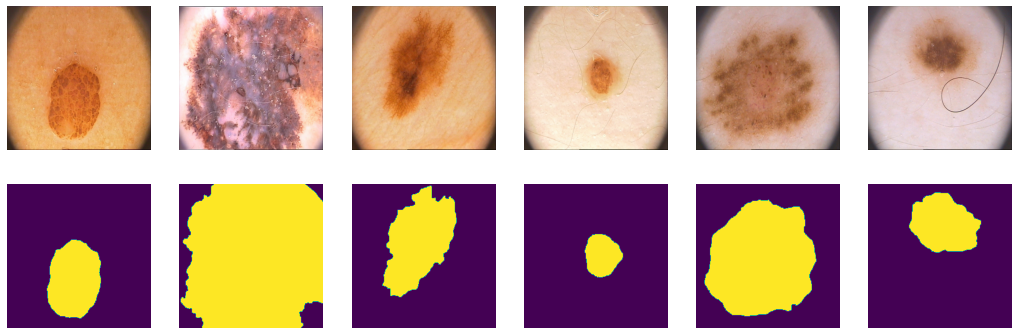

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])
    # print(X[i].shape)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [0]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [0]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

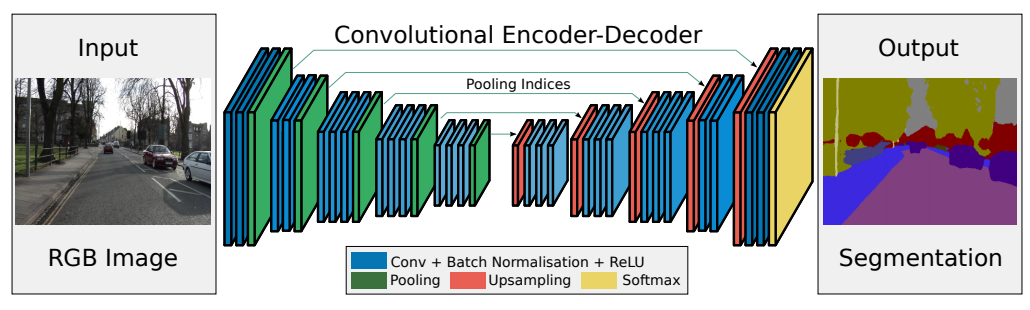

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import torchsummary
import gc

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
        def __init__(self):
          super().__init__()

          # encoder (downsampling)
          self.enc_conv0 =  nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )
          self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 256 -> 128

          self.enc_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )
          self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 128 -> 64

          self.enc_conv2  = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )
          self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 64 -> 32

          self.enc_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU()
              )
          self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 32 -> 16

          # decoder (upsampling)
          self.upsample0 =  nn.MaxUnpool2d(kernel_size = 2, stride = 2)# 16 -> 32
          self.dec_conv0 = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )

          self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 32 -> 64
          self.dec_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )

          self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 64 -> 128
          self.dec_conv2 = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )

          self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 128 -> 256
          self.dec_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding = 1),
              )

        def forward(self, x):
          # encoder
          e0 = self.enc_conv0(x)
          p0, indeces0 = self.pool0(e0)
          
          e1 = self.enc_conv1(p0)
          p1, indeces1 = self.pool1(e1)
          
          e2 = self.enc_conv2(p1)
          p2, indeces2 = self.pool2(e2)

          e3 = self.enc_conv3(p2)
          p3, indeces3 = self.pool3(e3)

          # decoder
          u0 = self.upsample0(p3,indeces3)         
          d0 = self.dec_conv0(u0)

          u1 = self.upsample1(d0,indeces2)
          d1 = self.dec_conv1(u1)
          
          u2 = self.upsample2(d1,indeces1)
          d2 = self.dec_conv2(u2)

          u3 = self.upsample3(d2,indeces0)
          d3 = self.dec_conv3(u3) # no activation
          return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # print ('intersection: ', intersection, '\n', 'union: ',union,'\n','iou: ', iou,'\n','thresholded: ',thresholded)
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
  y_pred = torch.sigmoid(y_pred)
  zero = torch.FloatTensor([0]).to(device)
  return torch.mean(torch.clamp(y_pred,0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, schedule = False):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch,Y_pred)# forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights
            if schedule == True:
              scheduler.step(loss)
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss )

        # show intermediate results
        model.eval()  # testing mode
        Y_hat =  model(X_val).cpu().detach().numpy()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss)+ ' score: %f' % score_model(model, iou_pytorch, data_val))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        # Y_pred = torch.sigmoid(Y_pred)
        scores += metric(Y_pred>0, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

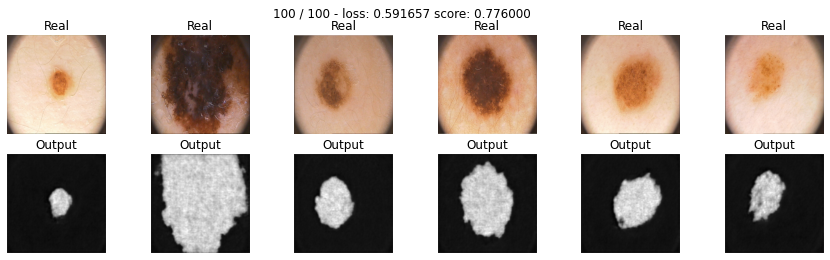

In [0]:
gc.collect()
torch.cuda.empty_cache()

model = SegNet().to(device)
max_epochs = 100
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)
train(model, opt, bce_loss, max_epochs, data_tr, data_val, schedule = True)

In [0]:
gc.collect()
torch.cuda.empty_cache()

score_model(model, iou_pytorch,data_val)

0.7759999930858612

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num =  torch.sum(2 * y_real * y_pred, dim = (-1,-2))
    den =  torch.sum(y_real + y_pred, dim = (-1,-2))
    return torch.mean(1 - (num + 1)/ (den + 1))

Проводим тестирование:

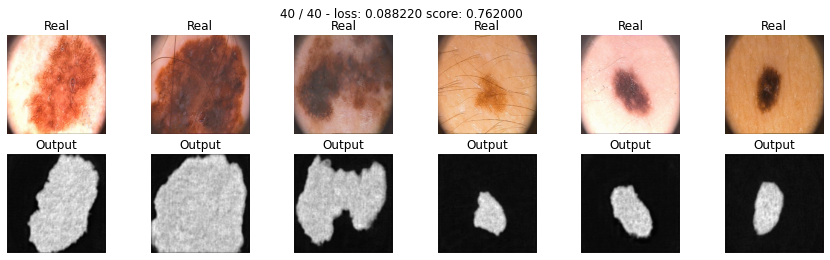

In [0]:
gc.collect()
torch.cuda.empty_cache()

model_dice = SegNet().to(device)

max_epochs = 40
opt = optim.Adam(model_dice.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(opt,28,0.5)
train(model_dice, opt, dice_loss, max_epochs, data_tr, data_val)

In [0]:
gc.collect()
torch.cuda.empty_cache()

score_model(model_dice, iou_pytorch, data_val)

0.7619999945163727

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
# def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # y_pred = torch.sigmoid(y_pred)
    # y_pred =  torch.clamp(y_pred,eps, 1-eps) # hint: torch.clamp
    # y_pred = y_pred.view(y_pred.shape[0], -1)
    # y_real = y_real.view(y_real.shape[0], -1)
    # pt = y_real * y_pred + (1 - y_real) * (1 - y_pred)
    # res = -(torch.log(pt + eps))*((1 - pt) ** gamma )
    # return res.mean()
# 

In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
  y_pred = torch.sigmoid(y_pred)
  y_pred =  torch.clamp(y_pred,eps, 1-eps)
  loss = (1 - y_pred) ** gamma * y_real * torch.log(y_pred + eps) \
    + (1 - y_real) * torch.log(1 - y_pred + eps)
  return -loss.mean()

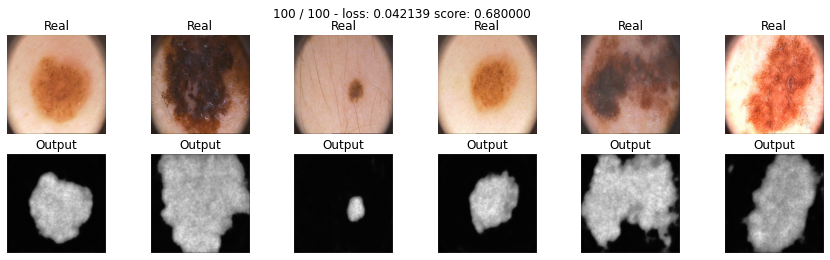

In [0]:
gc.collect()
torch.cuda.empty_cache()

model_focal = SegNet().to(device)

max_epochs = 100
opt = optim.Adam(model_focal.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)
train(model_focal, opt, focal_loss, max_epochs, data_tr, data_val, schedule = False)

In [0]:
gc.collect()
torch.cuda.empty_cache()

score_model(model_focal, iou_pytorch, data_val)

0.6800000369548798

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred, eps = 1e-3):
  alpha = 0.5
  y_pred = torch.sigmoid(y_pred)
  num = torch.sum(y_real * y_pred, dim = (-1,-2))
  den = y_real * y_pred + y_pred * (1 - y_real) * alpha +  (1-y_pred) * y_real * (1-alpha)
  res = 1 - num/(eps + torch.sum(den, dim = (-1,-2)))
  return res.mean()

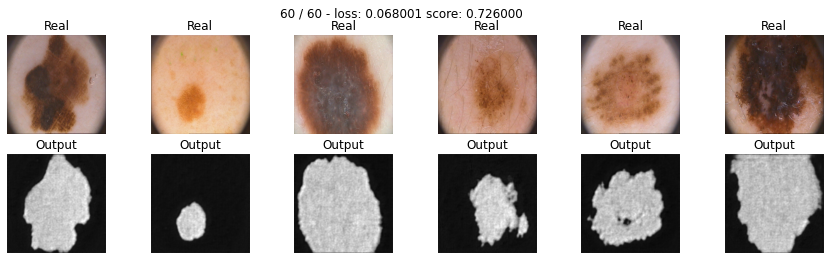

In [0]:
gc.collect()
torch.cuda.empty_cache()
model_tversky = SegNet().to(device)

max_epochs = 60
opt = optim.Adam(model_tversky.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt,24,0.5)
train(model_tversky, opt, tversky_loss, max_epochs, data_tr, data_val, schedule = True)

In [0]:
gc.collect()
torch.cuda.empty_cache()
score_model(model_tversky, iou_pytorch, data_val)

0.7260000109672546

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

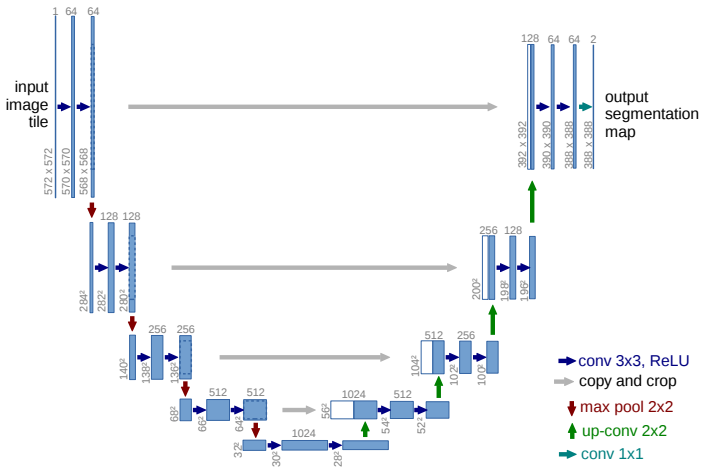

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
        def __init__(self):
          super().__init__()

          # encoder (downsampling)
          self.enc_conv0 =  nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )
          self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 256 -> 128

          self.enc_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )
          self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 128 -> 64

          self.enc_conv2  = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )
          self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 64 -> 32

          self.enc_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU()
              )
          self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 32 -> 16
  

          # bottleneck
          self.bottleneck_conv = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, padding = 0),
              nn.BatchNorm2d(512),
              nn.ReLU(),

              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding = 0),
              nn.BatchNorm2d(256),
              nn.ReLU()
          )


          # decoder (upsampling)
          self.upsample0 =  nn.MaxUnpool2d(kernel_size = 2, stride = 2)# 16 -> 32
          self.dec_conv0 = nn.Sequential(
              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )

          self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 32 -> 64
          self.dec_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )

          self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 64 -> 128
          self.dec_conv2 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )

          self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 128 -> 256
          self.dec_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding = 1),
              )

        def forward(self, x):
          # encoder
          e0 = self.enc_conv0(x)
          p0, indeces0 = self.pool0(e0)
          
          e1 = self.enc_conv1(p0)
          p1, indeces1 = self.pool1(e1)
          
          e2 = self.enc_conv2(p1)
          p2, indeces2 = self.pool2(e2)

          e3 = self.enc_conv3(p2)
          p3, indeces3 = self.pool3(e3)

          # bottleneck
          b = self.bottleneck_conv(p3)

          # decoder
          u0 = self.upsample0(b,indeces3)
          skip_con0 = torch.cat((e3,u0), dim = 1)
          d0 = self.dec_conv0(skip_con0)

          u1 = self.upsample1(d0,indeces2)
          skip_con1 = torch.cat((e2,u1), dim = 1)
          d1 = self.dec_conv1(skip_con1)
          

          u2 = self.upsample2(d1,indeces1)
          skip_con2 = torch.cat((e1,u2), dim = 1)
          d2 = self.dec_conv2(skip_con2)

          u3 = self.upsample3(d2,indeces0)
          skip_con3 = torch.cat((e0,u3), dim = 1)
          d3 = self.dec_conv3(skip_con3) # no activation
          return d3

Прошу обратить внимание на то, что такая архитектура нейронной сети, как на картинке, занимает больше памяти CUDA, чем ее предоставлено, поэтому я ровно в 2 раза уменьшил число каналов в каждом блоке сети.

In [0]:
unet_model = UNet().to(device)

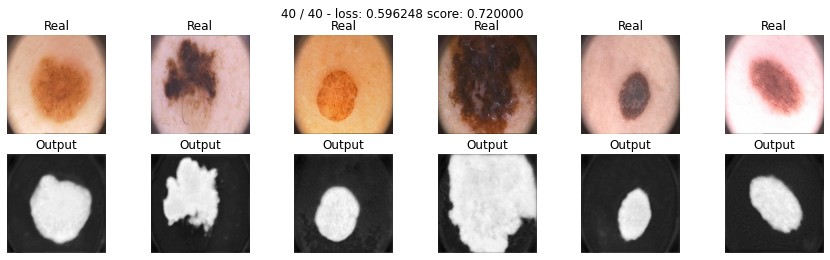

In [0]:
gc.collect()
torch.cuda.empty_cache()

opt = optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(opt,28,0.5)
train(unet_model, opt, bce_loss, 40, data_tr, data_val, schedule = True)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.7199999690055847

# U-Net modified

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
        def __init__(self):
          super().__init__()

          # encoder (downsampling)
          self.enc_conv0 =  nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )
          self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2,stride = 2, padding = 0)# 256 -> 128

          self.enc_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )
          self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2,stride = 2, padding = 0)# 128 -> 64

          self.enc_conv2  = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )
          self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2,stride = 2, padding = 0)# 64 -> 32

          self.enc_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU()
              )
          self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2,stride = 2, padding = 0)# 32 -> 16
          
          # bottleneck
          self.bottleneck_conv = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, padding = 0),
              nn.BatchNorm2d(512),
              nn.ReLU(),

              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding = 0),
              nn.BatchNorm2d(256),
              nn.ReLU()
          )
         
          # decoder (upsampling)
          self.upsample0 =  nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2,stride = 2, padding = 0)# 16 -> 32
          self.dec_conv0 = nn.Sequential(
              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )

          self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2,stride = 2, padding = 0) # 32 -> 64
          self.dec_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )

          self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2,stride = 2, padding = 0)  # 64 -> 128
          self.dec_conv2 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )

          self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2,stride = 2, padding = 0)  # 128 -> 256
          self.dec_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              
              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding = 1),
              )

        def forward(self, x):
          # encoder
          e0 = self.enc_conv0(x)
          p0 = self.pool0(e0)

          e1 = self.enc_conv1(p0)
          p1 = self.pool1(e1)
          
          e2 = self.enc_conv2(p1)
          p2 = self.pool2(e2)

          e3 = self.enc_conv3(p2)
          p3= self.pool3(e3)

          # decoder
          u0 = self.upsample0(p3)
          skip_con0 = torch.cat((e3,u0), dim = 1)
          d0 = self.dec_conv0(skip_con0)

          u1 = self.upsample1(d0)
          skip_con1 = torch.cat((e2,u1), dim = 1)
          d1 = self.dec_conv1(skip_con1)
          

          u2 = self.upsample2(d1)
          skip_con2 = torch.cat((e1,u2), dim = 1)
          d2 = self.dec_conv2(skip_con2)

          u3 = self.upsample3(d2)
          skip_con3 = torch.cat((e0,u3), dim = 1)
          d3 = self.dec_conv3(skip_con3) # no activation
          return d3

In [0]:
unet2_model = UNet2().to(device)


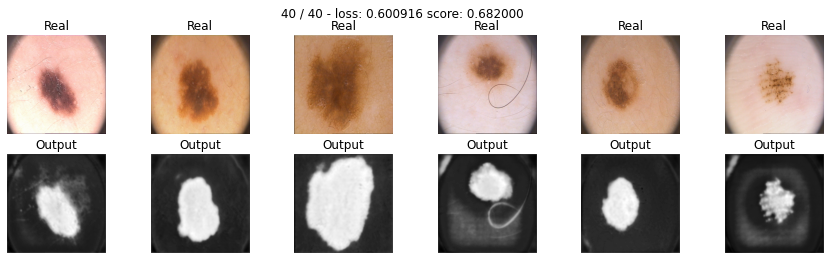

In [0]:
gc.collect()
torch.cuda.empty_cache()

opt = optim.Adam(unet2_model.parameters())
max_epochs = 40
scheduler = torch.optim.lr_scheduler.StepLR(opt,28,0.5)
train(unet2_model, opt, bce_loss, max_epochs, data_tr, data_val,schedule=True)

In [0]:
gc.collect()
torch.cuda.empty_cache()

score_model(unet2_model, iou_pytorch, data_val)

0.6819999814033508

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilationBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DilationBlock, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding =1, dilation = 1),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding =1, dilation = 1),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding =1, dilation = 1),
        nn.ReLU()
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding =1, dilation = 1),
        nn.ReLU()
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding =1, dilation = 1),
        nn.ReLU()
    )
    self.conv6 = nn.Sequential(
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding =1, dilation = 1),
        nn.ReLU()
    )

  def forward(self,x):
    conv_out1 = self.conv1(x)
    conv_out2 = self.conv2(conv_out1)
    conv_out3 = self.conv3(conv_out2)
    conv_out4 = self.conv4(conv_out3)
    conv_out5 = self.conv5(conv_out4)
    conv_out6 = self.conv6(conv_out5)
    output = conv_out1 + conv_out2 + conv_out3 + conv_out4 + conv_out5 + conv_out6
    return output

In [0]:
class DilatedUNet(nn.Module):
        def __init__(self):
          super().__init__()

          # encoder (downsampling)
          self.enc_conv0 =  nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 8, dilation = 8),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 8, dilation = 8),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )
          self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 256 -> 128

          self.enc_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 4, dilation = 4),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 4, dilation = 4),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )
          self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 128 -> 64

          self.enc_conv2  = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 2, dilation = 2),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 2, dilation = 2),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )
          self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 64 -> 32

          self.enc_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  padding = 1, dilation = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1, dilation = 1),
              nn.BatchNorm2d(256),
              nn.ReLU()
              )
          self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)# 32 -> 16
  

          # bottleneck
          self.bottleneck_conv = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, padding = 0),
              nn.ReLU(),

              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding = 0),
              nn.ReLU()
          )


          # decoder (upsampling)
          self.upsample0 =  nn.MaxUnpool2d(kernel_size = 2, stride = 2)# 16 -> 32
          self.dec_conv0 = nn.Sequential(
              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU()
              )

          self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 32 -> 64
          self.dec_conv1 = nn.Sequential(
              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU()
              )

          self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 64 -> 128
          self.dec_conv2 = nn.Sequential(
              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU()
              )

          self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)  # 128 -> 256
          self.dec_conv3 = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding = 1),
              )

        def forward(self, x):
          # encoder
          e0 = self.enc_conv0(x)
          p0, indeces0 = self.pool0(e0)
          
          e1 = self.enc_conv1(p0)
          p1, indeces1 = self.pool1(e1)
          
          e2 = self.enc_conv2(p1)
          p2, indeces2 = self.pool2(e2)

          e3 = self.enc_conv3(p2)
          p3, indeces3 = self.pool3(e3)

          # bottleneck
          b = self.bottleneck_conv(p3)

          # decoder
          u0 = self.upsample0(b,indeces3)
          skip_con0 = torch.cat((e3,u0), dim = 1)
          d0 = self.dec_conv0(skip_con0)

          u1 = self.upsample1(d0,indeces2)
          skip_con1 = torch.cat((e2,u1), dim = 1)
          d1 = self.dec_conv1(skip_con1)
          

          u2 = self.upsample2(d1,indeces1)
          skip_con2 = torch.cat((e1,u2), dim = 1)
          d2 = self.dec_conv2(skip_con2)

          u3 = self.upsample3(d2,indeces0)
          skip_con3 = torch.cat((e0,u3), dim = 1)
          d3 = self.dec_conv3(skip_con3) # no activation
          return d3

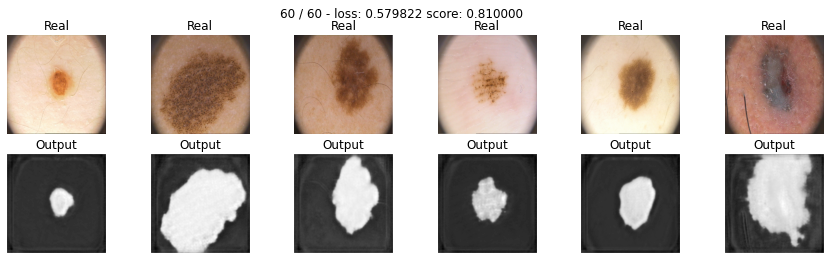

In [0]:
gc.collect()
torch.cuda.empty_cache()

model = DilatedUNet().to(device)
opt = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(opt,16,0.5)
train(model, opt, bce_loss, 60, data_tr, data_val, schedule = True)

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



Проведем сравнение Segnet, DilatedSegnet, U-Net и modified U-Net с различными функциями лосса.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, data_ts, schedule = False, save = False):
    X_val, Y_val = next(iter(data_val))
    X_test, Y_test = next(iter(data_ts))

    val_accuracies = []
    test_accuracies = []
    train_loss = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch,Y_pred)# forward-pass
            loss.backward()  # backward-pass
            if (schedule == True):
              scheduler.step(loss)
            opt.step() # update weights
             
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        
        toc = time()
        print('loss: %f' % avg_loss )

        # show intermediate results
        model.eval()  # testing mode
        Y_hat =  model(X_val).cpu().detach().numpy()# detach and put into cpu

        train_loss.append(avg_loss)
        Y_score_val = score_model(model, iou_pytorch, data_val)
        if (len(val_accuracies) > 0 and save == True and Y_score_val > max(val_accuracies)):
          save_checkpoint(f'model.pth', model, opt)
        Y_score_test = score_model(model, iou_pytorch, data_ts)
        val_accuracies.append(Y_score_val)
        test_accuracies.append(Y_score_test)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss)+ ' score: %f' % score_model(model, iou_pytorch, data_val))
        plt.show()
    return val_accuracies, test_accuracies, train_loss

In [0]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

## SegNet

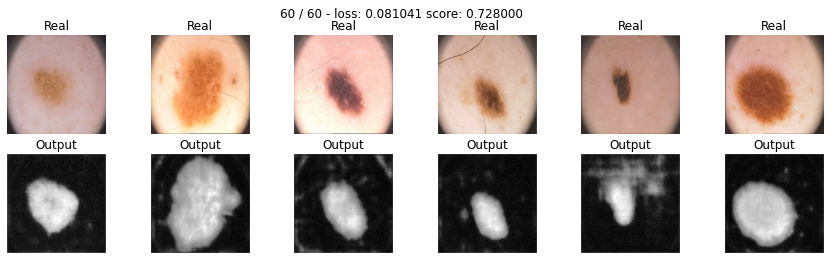

In [0]:
gc.collect()
torch.cuda.empty_cache()

losses = [bce_loss, tversky_loss, dice_loss, focal_loss]
max_epochs = 60
history = {}

for loss in losses:
  model = SegNet().to(device)
  opt = optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)

  val_accuracies, test_accuracies, train_loss = train(model, opt, loss, max_epochs, data_tr, data_val, data_ts, schedule = True, save = False)
  history[loss.__name__] = [val_accuracies, test_accuracies, train_loss]

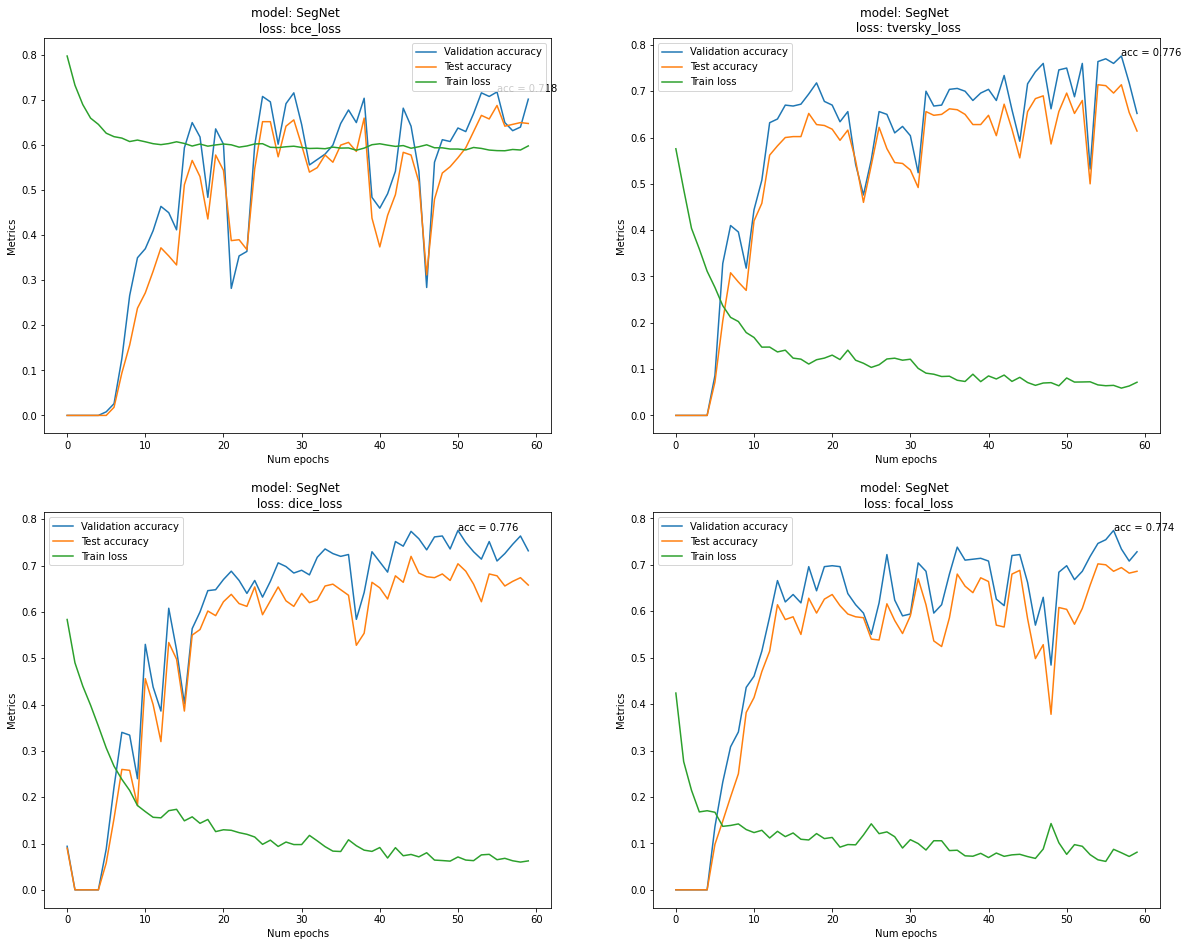

In [0]:
plt.figure(figsize = (20,16))
for loss,i in zip(losses, range(len(losses))): 
  plt.subplot(2,2,i+1)
  plt.plot(history[(loss.__name__)][0], label = 'Validation accuracy')
  plt.plot(history[(loss.__name__)][1], label = 'Test accuracy')
  plt.plot(history[(loss.__name__)][2], label = 'Train loss')
  max_val_acc = max(history[(loss.__name__)][0])
  max_val_pos = np.argmax(history[(loss.__name__)][0])
  plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
  plt.xlabel('Num epochs')
  plt.ylabel('Metrics')
  plt.legend()
  plt.title(f'model: SegNet \n loss: {loss.__name__}')

## U-Net


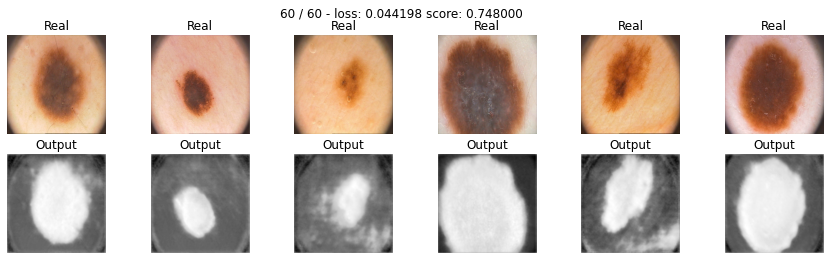

In [0]:
gc.collect()
torch.cuda.empty_cache()

losses = [bce_loss, tversky_loss, dice_loss, focal_loss]
max_epochs = 60
history = {}

for loss in losses:
  model = UNet().to(device)
  opt = optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)

  val_accuracies, test_accuracies, train_loss = train(model, opt, loss, max_epochs, data_tr, data_val, data_ts, schedule = True, save = False)
  history[loss.__name__] = [val_accuracies, test_accuracies, train_loss]

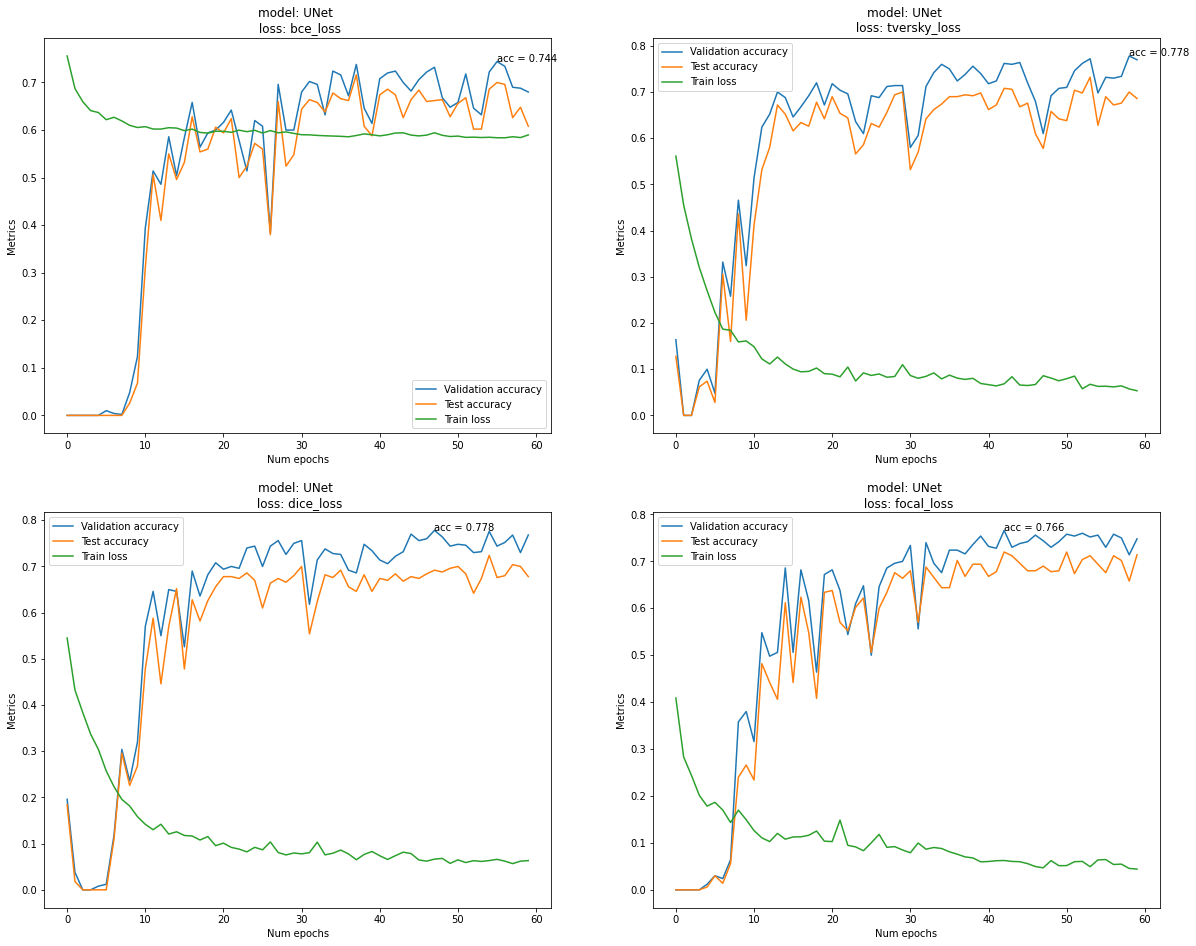

In [0]:
plt.figure(figsize = (20,16))
for loss,i in zip(losses, range(len(losses))): 
  plt.subplot(2,2,i+1)
  plt.plot(history[(loss.__name__)][0], label = 'Validation accuracy')
  plt.plot(history[(loss.__name__)][1], label = 'Test accuracy')
  plt.plot(history[(loss.__name__)][2], label = 'Train loss')
  max_val_acc = max(history[(loss.__name__)][0])
  max_val_pos = np.argmax(history[(loss.__name__)][0])
  plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
  plt.xlabel('Num epochs')
  plt.ylabel('Metrics')
  plt.legend()
  plt.title(f'model: UNet \n loss: {loss.__name__}')

## U-Net modofied

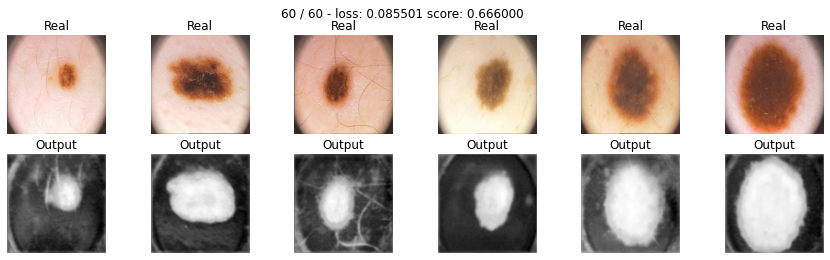

In [0]:
gc.collect()
torch.cuda.empty_cache()

losses = [bce_loss, tversky_loss, dice_loss, focal_loss]
max_epochs = 60
history = {}

for loss in losses:
  model = UNet2().to(device)
  opt = optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)

  val_accuracies, test_accuracies, train_loss = train(model, opt, loss, max_epochs, data_tr, data_val, data_ts, schedule = True, save = False)
  history[loss.__name__] = [val_accuracies, test_accuracies, train_loss]

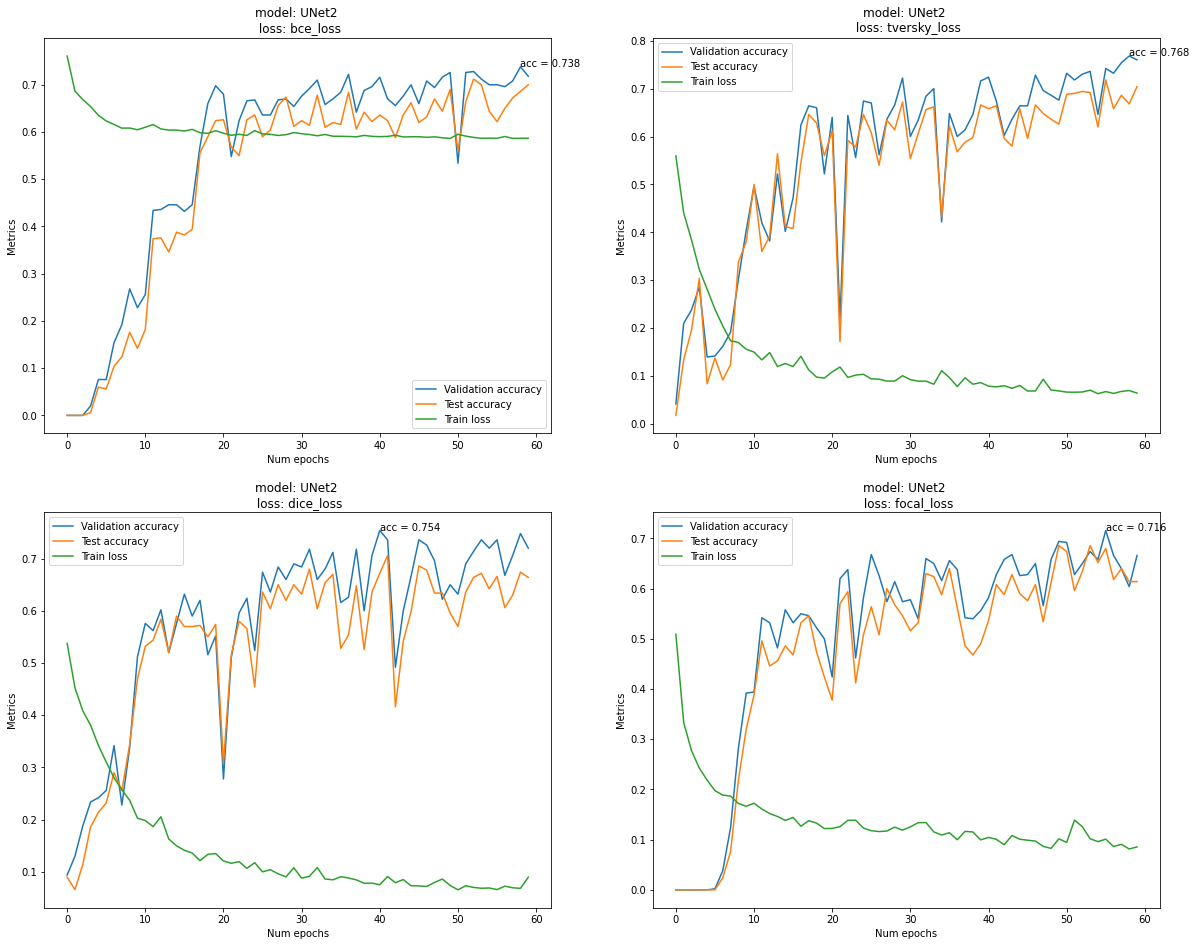

In [0]:
plt.figure(figsize = (20,16))
for loss,i in zip(losses, range(len(losses))): 
  plt.subplot(2,2,i+1)
  plt.plot(history[(loss.__name__)][0], label = 'Validation accuracy')
  plt.plot(history[(loss.__name__)][1], label = 'Test accuracy')
  plt.plot(history[(loss.__name__)][2], label = 'Train loss')
  max_val_acc = max(history[(loss.__name__)][0])
  max_val_pos = np.argmax(history[(loss.__name__)][0])
  plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
  plt.xlabel('Num epochs')
  plt.ylabel('Metrics')
  plt.legend()
  plt.title(f'model: UNet2 \n loss: {loss.__name__}')

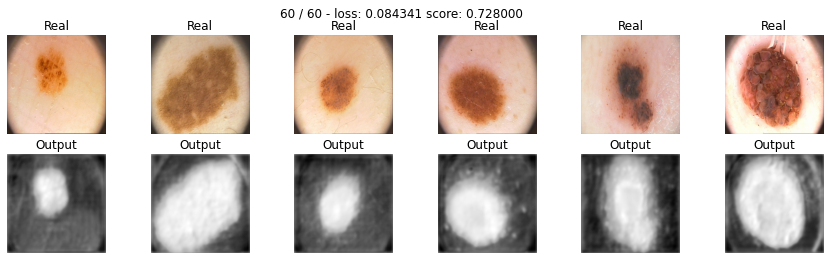

In [0]:
gc.collect()
torch.cuda.empty_cache()

losses = [bce_loss, tversky_loss, dice_loss, focal_loss]
max_epochs = 60
history = {}

for loss in losses:
  model = UNet2().to(device)
  opt = optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)

  val_accuracies, test_accuracies, train_loss = train(model, opt, loss, max_epochs, data_tr, data_val, data_ts, schedule = True, save = False)
  history[loss.__name__] = [val_accuracies, test_accuracies, train_loss]

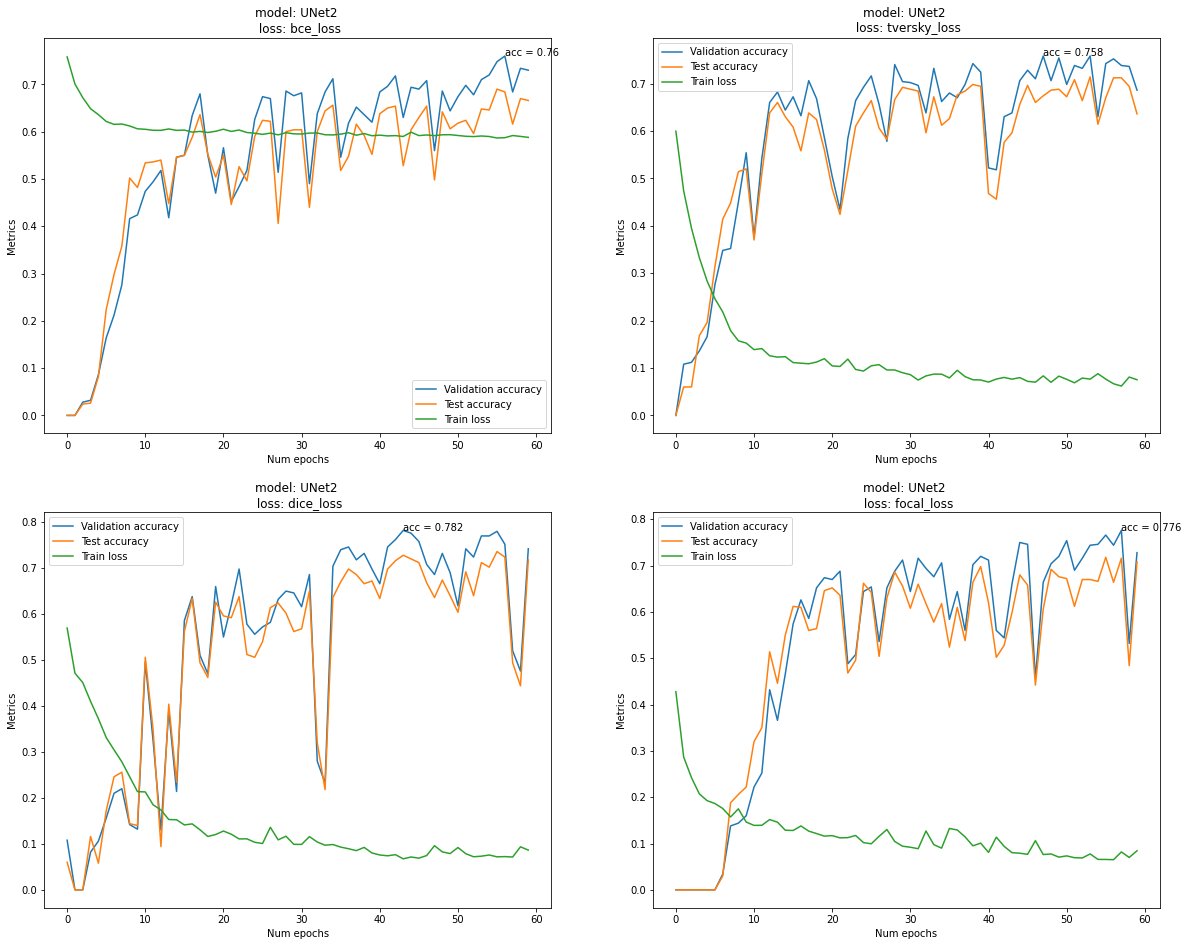

In [0]:
plt.figure(figsize = (20,16))
for loss,i in zip(losses, range(len(losses))): 
  plt.subplot(2,2,i+1)
  plt.plot(history[(loss.__name__)][0], label = 'Validation accuracy')
  plt.plot(history[(loss.__name__)][1], label = 'Test accuracy')
  plt.plot(history[(loss.__name__)][2], label = 'Train loss')
  max_val_acc = max(history[(loss.__name__)][0])
  max_val_pos = np.argmax(history[(loss.__name__)][0])
  plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
  plt.xlabel('Num epochs')
  plt.ylabel('Metrics')
  plt.legend()
  plt.title(f'model: UNet2 \n loss: {loss.__name__}')

## Dilated U-Net

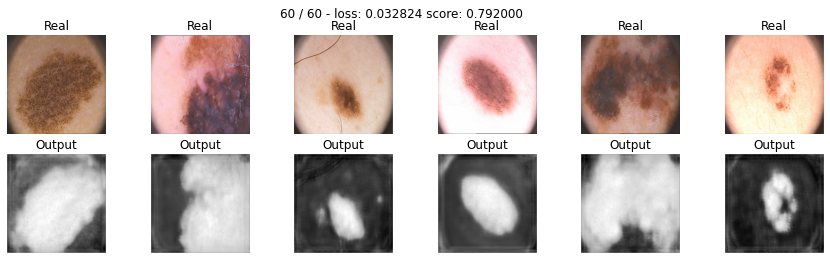

In [0]:
gc.collect()
torch.cuda.empty_cache()

losses = [bce_loss, tversky_loss, dice_loss, focal_loss]
max_epochs = 60

history = {}

for loss in losses:
  model = DilatedUNet().to(device)
  opt = optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.StepLR(opt,40,0.5)

  val_accuracies, test_accuracies, train_loss = train(model, opt, loss, max_epochs, data_tr, data_val, data_ts, schedule = True, save = False)
  history[loss.__name__] = [val_accuracies, test_accuracies, train_loss]

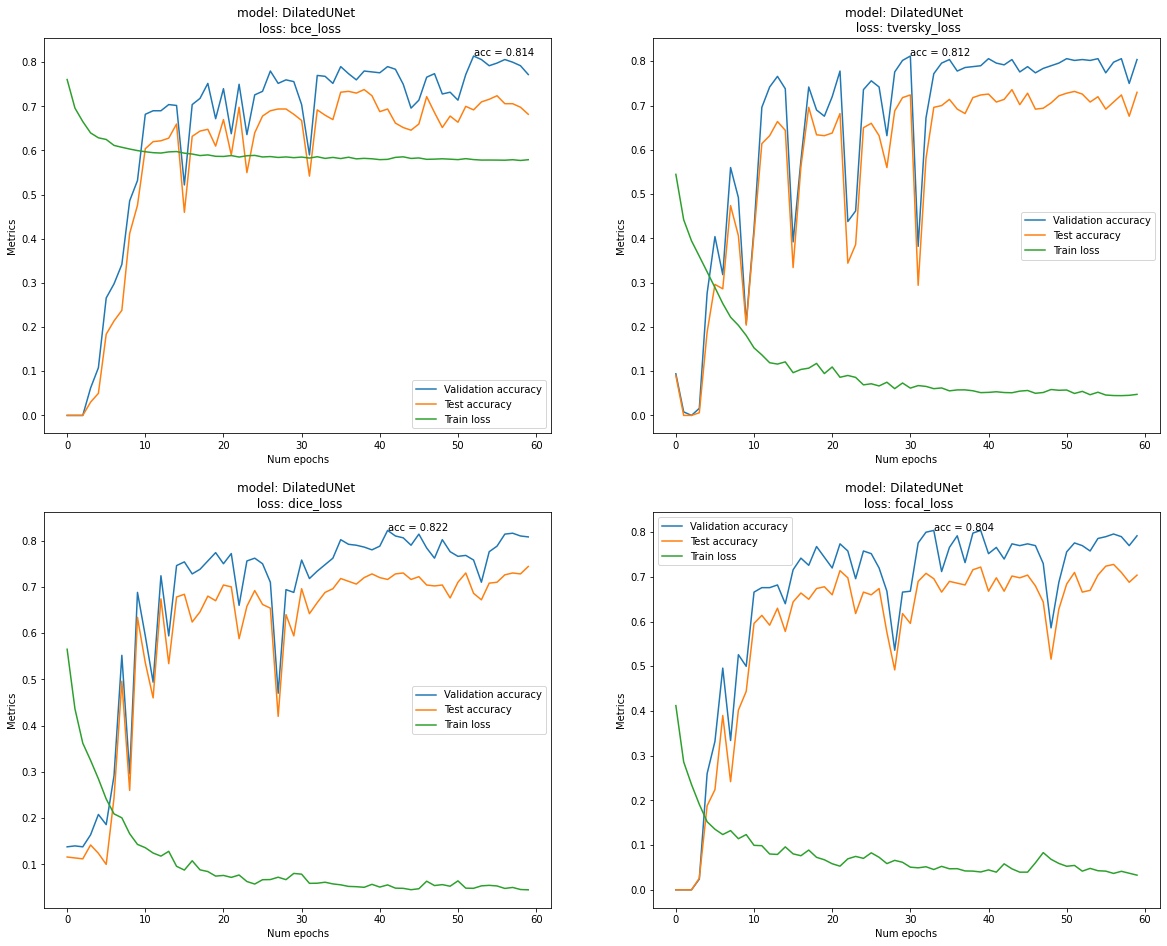

In [0]:
plt.figure(figsize = (20,16))
for loss,i in zip(losses, range(len(losses))): 
  plt.subplot(2,2,i+1)
  plt.plot(history[(loss.__name__)][0], label = 'Validation accuracy')
  plt.plot(history[(loss.__name__)][1], label = 'Test accuracy')
  plt.plot(history[(loss.__name__)][2], label = 'Train loss')
  max_val_acc = max(history[(loss.__name__)][0])
  max_val_pos = np.argmax(history[(loss.__name__)][0])
  plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
  plt.xlabel('Num epochs')
  plt.ylabel('Metrics')
  plt.legend()
  plt.title(f'model: DilatedUNet \n loss: {loss.__name__}')

# Подбор наилучшей архитектуры

Исходя из лучших скоров на валидации, можно увидеть, что наилучший скор выдает модель DilatedUnet, она показывает себя явно лучше других.

Можно было бы добавить больше слоев (не 4 блока в энкодере и декодере, а , к примеру, 5), но из-за ограниченных ресурсов памяти CUDA сделать это не представляется возможным. Потому, единственным способом оптимизации является подбор lr/оптимизатора/увеличение кол-ва эпох.

О качестве модели будем судить по ее скоре на валидации т.к. как правило в реальных задачах тестовые данные вообще нам не известны, и мы вынуждены разбивать трейновую выборку на трейновую меньшего размера и валидационную


## BCE LOSS

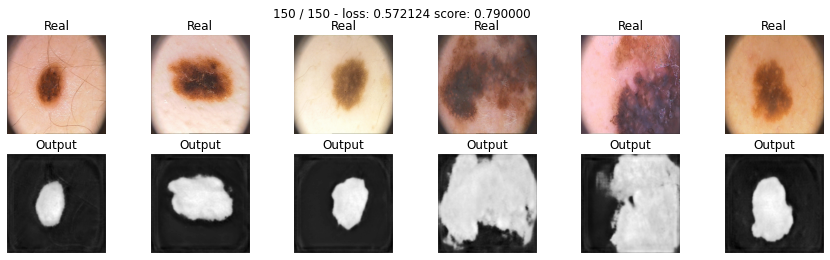

In [0]:
gc.collect()
torch.cuda.empty_cache()

max_epochs = 150

model = DilatedUNet().to(device)
opt = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,16,0.5)
val_accuracies, test_accuracies, train_loss = train(model, opt, bce_loss, max_epochs, 
                                                    data_tr, data_val, data_ts, schedule = True, save = True)

Text(0.5, 1.0, 'model: DilatedUNet \n loss: bce loss')

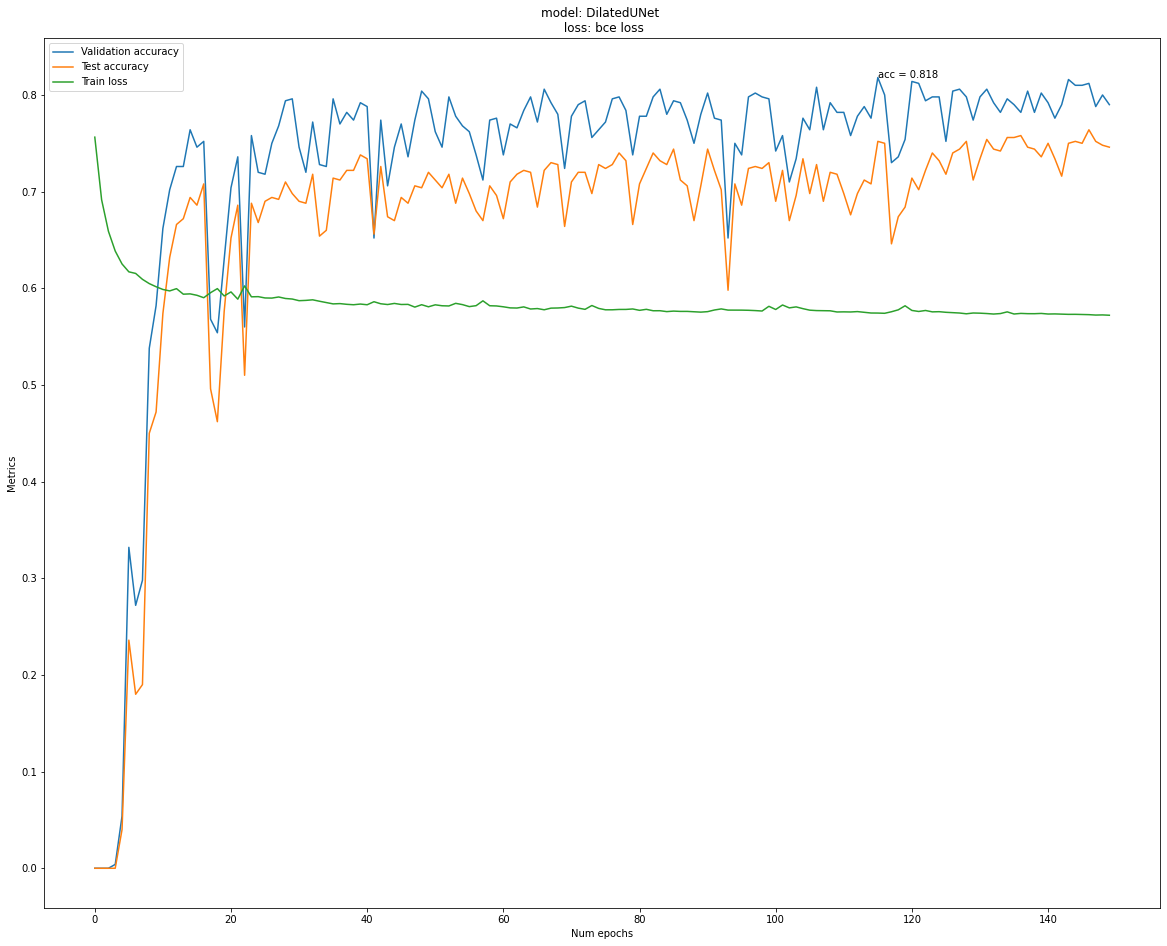

In [0]:
plt.figure(figsize = (20,16))
plt.plot(val_accuracies, label = 'Validation accuracy')
plt.plot(test_accuracies, label = 'Test accuracy')
plt.plot(train_loss, label = 'Train loss')
max_val_acc = max(val_accuracies)
max_val_pos = np.argmax(val_accuracies)
plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
plt.xlabel('Num epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title(f'model: DilatedUNet \n loss: bce loss')

In [0]:
load_checkpoint('model.pth', model, opt)
print ('validation accuracy ' ,score_model(model, iou_pytorch, data_val))
print ('test accuracy ' ,score_model(model, iou_pytorch, data_ts))

model loaded from model.pth
validation accuracy  0.8180000185966492
test accuracy  0.7520000040531158


## DICE LOSS


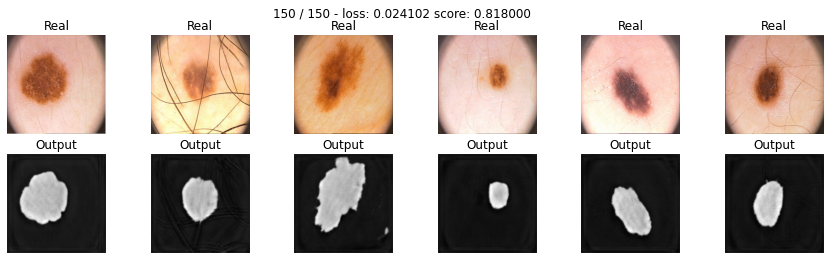

In [0]:
gc.collect()
torch.cuda.empty_cache()

max_epochs = 150

model = DilatedUNet().to(device)
opt = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,16,0.5)
val_accuracies, test_accuracies, train_loss = train(model, opt, dice_loss, max_epochs, 
                                                    data_tr, data_val, data_ts, schedule = True, save = True)

Text(0.5, 1.0, 'model: DilatedUNet \n loss: dice loss')

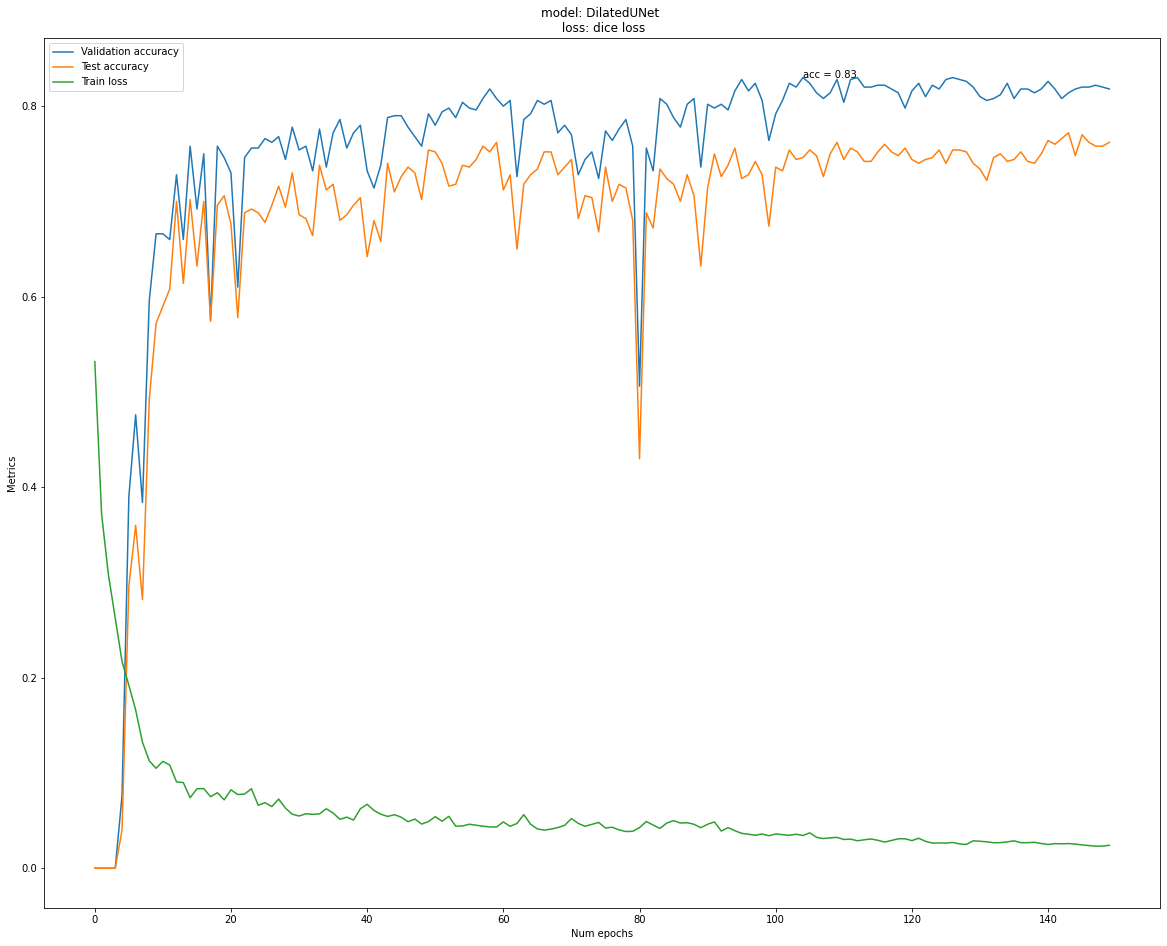

In [0]:
plt.figure(figsize = (20,16))
plt.plot(val_accuracies, label = 'Validation accuracy')
plt.plot(test_accuracies, label = 'Test accuracy')
plt.plot(train_loss, label = 'Train loss')
max_val_acc = max(val_accuracies)
max_val_pos = np.argmax(val_accuracies)
plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
plt.xlabel('Num epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title(f'model: DilatedUNet \n loss: dice loss')

In [0]:
load_checkpoint('model.pth', model, opt)
print ('validation accuracy ' ,score_model(model, iou_pytorch, data_val))
print ('test accuracy ' ,score_model(model, iou_pytorch, data_ts))

model loaded from model.pth
validation accuracy  0.8299999833106995
test accuracy  0.7459999918937683


## TVERSKY LOSS

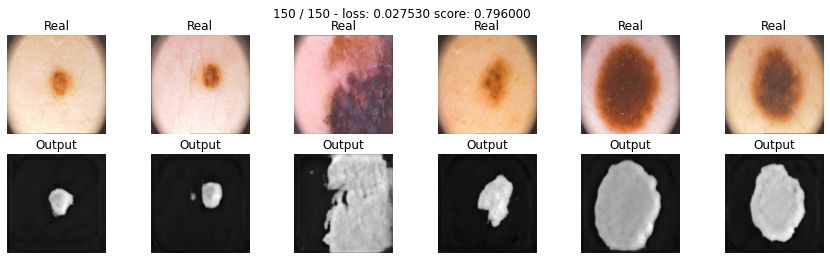

In [0]:
gc.collect()
torch.cuda.empty_cache()

max_epochs = 150

model = DilatedUNet().to(device)
opt = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,16,0.5)
val_accuracies, test_accuracies, train_loss = train(model, opt, tversky_loss, max_epochs, 
                                                    data_tr, data_val, data_ts, schedule = True, save = True)

Text(0.5, 1.0, 'model: DilatedUNet \n loss: tversky loss')

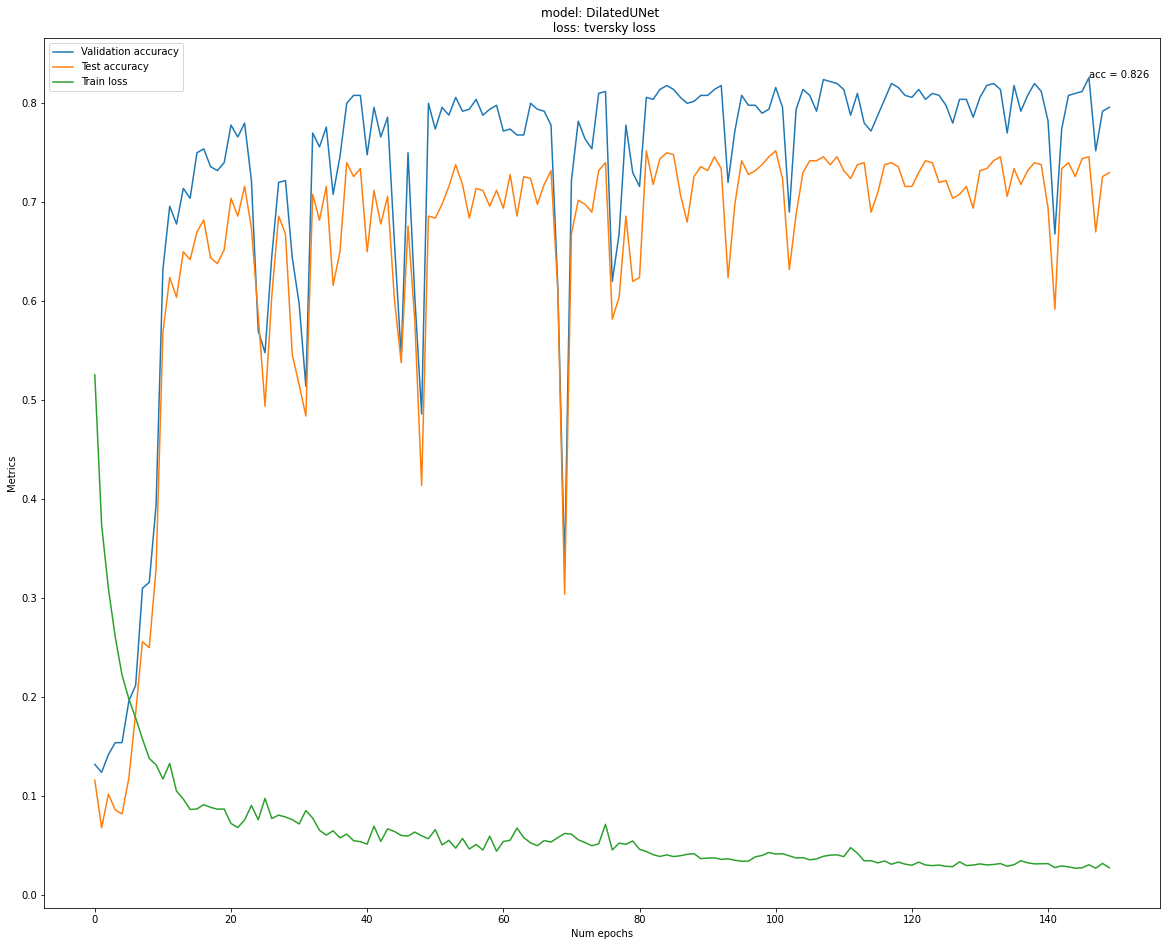

In [0]:
plt.figure(figsize = (20,16))
plt.plot(val_accuracies, label = 'Validation accuracy')
plt.plot(test_accuracies, label = 'Test accuracy')
plt.plot(train_loss, label = 'Train loss')
max_val_acc = max(val_accuracies)
max_val_pos = np.argmax(val_accuracies)
plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
plt.xlabel('Num epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title(f'model: DilatedUNet \n loss: tversky loss')

In [0]:
load_checkpoint('model.pth', model, opt)
print ('validation accuracy ' ,score_model(model, iou_pytorch, data_val))
print ('test accuracy ' ,score_model(model, iou_pytorch, data_ts))

model loaded from model.pth
validation accuracy  0.8260000348091125
test accuracy  0.7460000514984131


## FOCAL LOSS

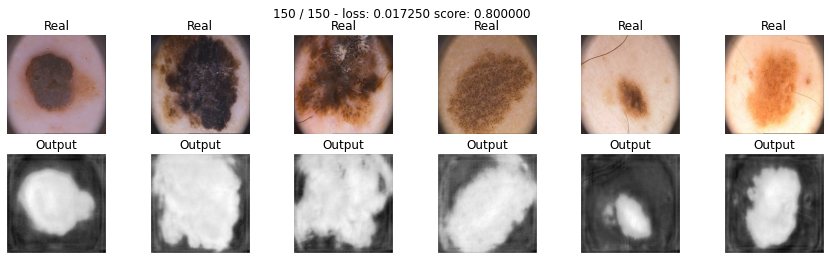

In [0]:
gc.collect()
torch.cuda.empty_cache()

max_epochs = 150

model = DilatedUNet().to(device)
opt = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,16,0.5)
val_accuracies, test_accuracies, train_loss = train(model, opt, focal_loss, max_epochs, 
                                                    data_tr, data_val, data_ts, schedule = True, save = True)

Text(0.5, 1.0, 'model: DilatedUNet \n loss: focal loss')

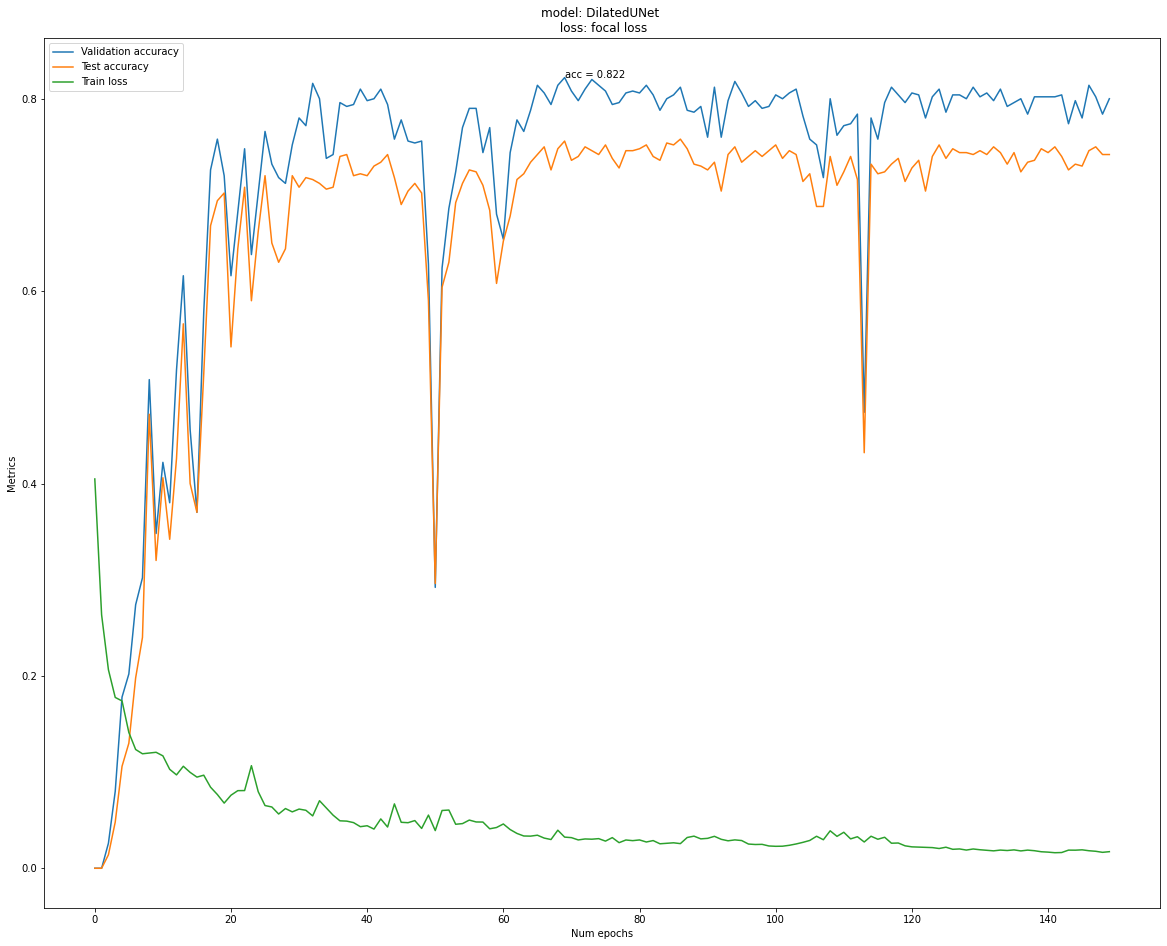

In [0]:
plt.figure(figsize = (20,16))
plt.plot(val_accuracies, label = 'Validation accuracy')
plt.plot(test_accuracies, label = 'Test accuracy')
plt.plot(train_loss, label = 'Train loss')
max_val_acc = max(val_accuracies)
max_val_pos = np.argmax(val_accuracies)
plt.annotate(f"acc = {round(max_val_acc,3)}", xy = (max_val_pos,max_val_acc))
plt.xlabel('Num epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title(f'model: DilatedUNet \n loss: focal loss')

In [0]:
load_checkpoint('model.pth', model, opt)
print ('validation accuracy ' ,score_model(model, iou_pytorch, data_val))
print ('test accuracy ' ,score_model(model, iou_pytorch, data_ts))

model loaded from model.pth
validation accuracy  0.8219999969005585
test accuracy  0.7560000121593475


Итого, получаем, что лучшей моделью для решения сегментационной задачи является Dilated U-Net с ошибкой dice_loss приведенной выше архитектурой со следующими значениями метрик:

validation accuracy: 0.83

test accuracy: 0.746